# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Признаки** \
DateCrawled — дата скачивания анкеты из базы\
VehicleType — тип автомобильного кузова\
RegistrationYear — год регистрации автомобиля\
Gearbox — тип коробки передач\
Power — мощность (л. с.)\
Model — модель автомобиля\
Kilometer — пробег (км)\
RegistrationMonth — месяц регистрации автомобиля\
FuelType — тип топлива\
Brand — марка автомобиля\
Repaired — была машина в ремонте или нет\
DateCreated — дата создания анкеты\
NumberOfPictures — количество фотографий автомобиля\
PostalCode — почтовый индекс владельца анкеты (пользователя)\
LastSeen — дата последней активности пользователя

**Целевой признак** \
Price — цена (евро)

## План
* Подготовка данных
* Обучение моделей CatBoostRegressor, LGBRegressor, LinearRegression
* Анализ времени обучения, времени предсказания и качества моделей
* Проверка лучшей модели на тестовой выборке
* Вывод

## Подготовка данных

In [1]:
import datetime
import pandas as pd
import seaborn as sns
import numpy as np
import pickle
import joblib
!pip install optuna 
import optuna
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor

     |████████████████████████████████| 348 kB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 42.2 MB 28 kB/s s eta 0:00:01
     |████████████████████████████████| 81 kB 6.4 MB/s  eta 0:00:01
     |████████████████████████████████| 147 kB 86.8 MB/s eta 0:00:01
     |████████████████████████████████| 50 kB 7.8 MB/s  eta 0:00:01
     |████████████████████████████████| 112 kB 94.6 MB/s eta 0:00:01
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11107 sha256=8066103c4729144038a0da13da80c8f9237ea676d3c85f20c5e1fd6d79083905
  Stored in directory: /home/jovyan/.cache/pip/wheels/0c/09/9e/49e21a6840ef7955b06d47394afef0058f0378c0914e48b8b8
Successfully built pyperclip
  Attempting uninstall: scipy
    Found existing installation: scipy 1.9.1
    Uninstalling scipy-1.9.1:
      Successfully uninstalled scipy-1.9.1


In [2]:
df = pd.read_csv('/datasets/autos.csv')

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [6]:
df.duplicated().sum()

4

In [7]:
df = df.drop_duplicates();

In [8]:
df.duplicated().sum()

0

Удалили дубликаты

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> 
    
 

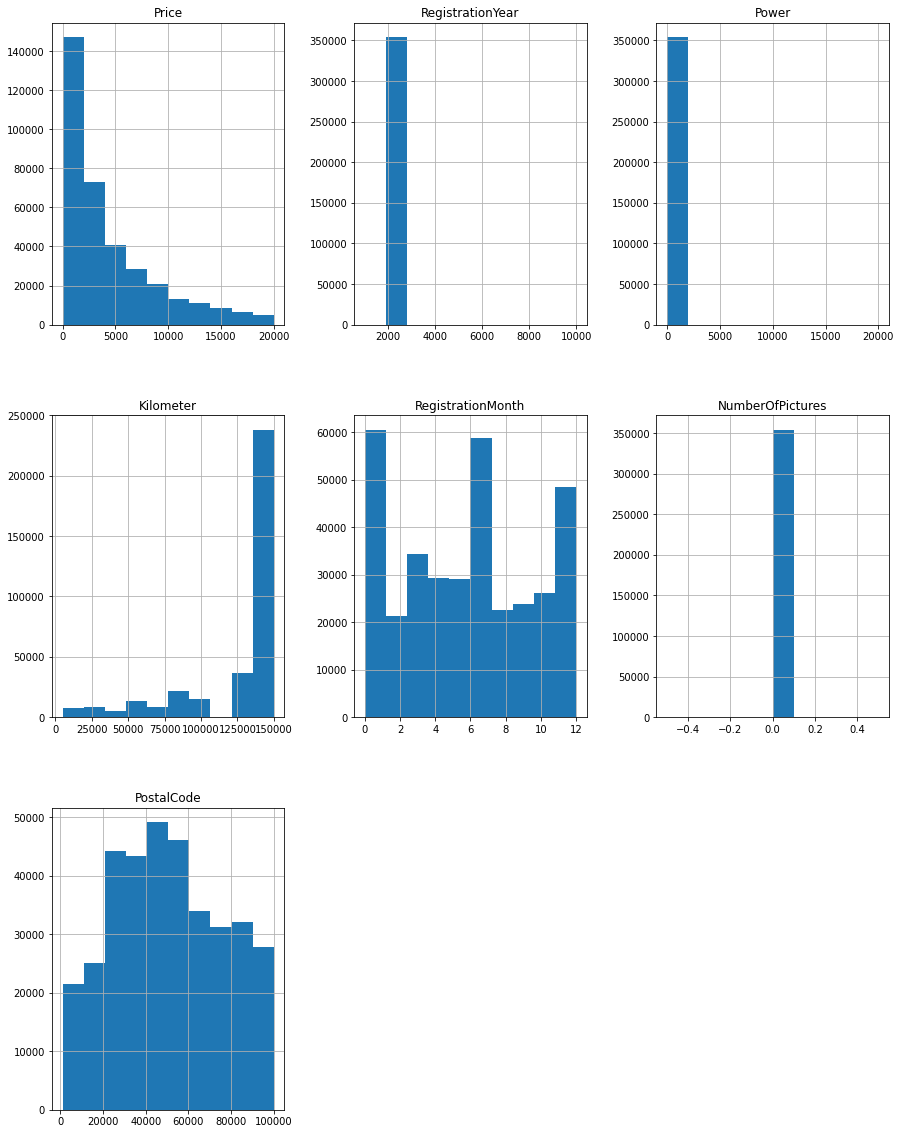

In [9]:
df.hist(figsize=(15, 20));

In [10]:
#Посчитаем количество пустых значений
(
    (df.isna().mean()*100)
    .sort_values(ascending=False)
    .to_frame()
    .rename(columns = {0:'percent_space'})
    .style.background_gradient('coolwarm').format("{:.1f}")
)

,percent_space
Repaired,20.1
VehicleType,10.6
FuelType,9.3
Gearbox,5.6
Model,5.6
DateCrawled,0.0
Price,0.0
RegistrationYear,0.0
Power,0.0
Kilometer,0.0


**Предобработка данных:**
* Минимальное значение цены начинается с 0, такого было не может, и поскольку, это целевой признак - данные необходимо удалить
* Год регистрации также указан не верно (минимальный 1000, максимальный - 9999)
* В месяце регистрации есть значение 0
* Ни в одном объявлении нет фотографий (этот столбец удалим)
* Минимальное кол-во лошадиных сил - 0 (машина спросто стоит?:)), максиальное - 2000 (такого не может быть)
* Почтовый адрес владельца анкеты нам не нужен, также удалим

In [11]:
df['Price'].value_counts()

0        10772
500       5670
1500      5394
1000      4648
1200      4594
         ...  
13180        1
10879        1
2683         1
634          1
8188         1
Name: Price, Length: 3731, dtype: int64

In [12]:
df_new = df.query('Price > 0')

count    343593.000000
mean       4555.147363
std        4515.076200
min           1.000000
25%        1200.000000
50%        2890.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

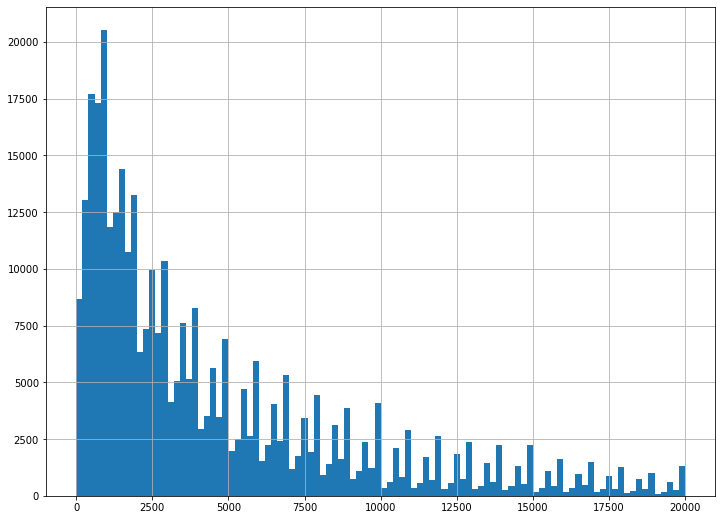

In [13]:
df_new['Price'].hist(bins=100, figsize=(12,9))
df_new['Price'].describe()

In [14]:
df_new['DateCrawled'] = pd.DatetimeIndex(df_new['DateCrawled']).year.astype('int64')

/tmp/ipykernel_48/919843118.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['DateCrawled'] = pd.DatetimeIndex(df_new['DateCrawled']).year.astype('int64')


In [15]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 343593 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        343593 non-null  int64 
 1   Price              343593 non-null  int64 
 2   VehicleType        309843 non-null  object
 3   RegistrationYear   343593 non-null  int64 
 4   Gearbox            326238 non-null  object
 5   Power              343593 non-null  int64 
 6   Model              326072 non-null  object
 7   Kilometer          343593 non-null  int64 
 8   RegistrationMonth  343593 non-null  int64 
 9   FuelType           314134 non-null  object
 10  Brand              343593 non-null  object
 11  Repaired           277727 non-null  object
 12  DateCreated        343593 non-null  object
 13  NumberOfPictures   343593 non-null  int64 
 14  PostalCode         343593 non-null  int64 
 15  LastSeen           343593 non-null  object
dtypes: int64(8), object(

In [16]:
df_new = df_new.loc[(df_new['RegistrationYear']>=1950) & (df_new['RegistrationYear']<=df_new['DateCrawled'])]

In [17]:
df_new['RegistrationYear'].sort_values().unique() #

array([1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960,
       1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016])

In [18]:
# Удалим лишние столбцы
df_new=df_new.drop(['DateCrawled','DateCreated', 'RegistrationMonth', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 329635 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             329635 non-null  int64 
 1   VehicleType       309738 non-null  object
 2   RegistrationYear  329635 non-null  int64 
 3   Gearbox           314090 non-null  object
 4   Power             329635 non-null  int64 
 5   Model             314053 non-null  object
 6   Kilometer         329635 non-null  int64 
 7   FuelType          305512 non-null  object
 8   Brand             329635 non-null  object
 9   Repaired          269827 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.7+ MB


In [19]:
df_new['Brand'].sort_values().unique() #Дубликатов бренда не найдено

array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant',
       'volkswagen', 'volvo'], dtype=object)

In [20]:
df_new['Power'].sort_values().unique()

array([    0,     1,     2,     3,     4,     5,     6,     7,     8,
           9,    10,    11,    12,    13,    14,    15,    16,    17,
          18,    19,    20,    21,    22,    23,    24,    25,    26,
          27,    28,    29,    30,    31,    32,    33,    34,    35,
          36,    37,    38,    39,    40,    41,    42,    43,    44,
          45,    46,    47,    48,    49,    50,    51,    52,    53,
          54,    55,    56,    57,    58,    59,    60,    61,    62,
          63,    64,    65,    66,    67,    68,    69,    70,    71,
          72,    73,    74,    75,    76,    77,    78,    79,    80,
          81,    82,    83,    84,    85,    86,    87,    88,    89,
          90,    91,    92,    93,    94,    95,    96,    97,    98,
          99,   100,   101,   102,   103,   104,   105,   106,   107,
         108,   109,   110,   111,   112,   113,   114,   115,   116,
         117,   118,   119,   120,   121,   122,   123,   124,   125,
         126,   127,

In [21]:
df_new = df_new.loc[(df_new['Power']>15) & (df_new['Power']<1000)]

In [22]:
df_new.isna().sum()

Price                   0
VehicleType         11027
RegistrationYear        0
Gearbox              5369
Power                   0
Model               11006
Kilometer               0
FuelType            15550
Brand                   0
Repaired            42884
dtype: int64

In [23]:
columns_to_fill = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired', 'Brand']
df_new[columns_to_fill] = df_new[columns_to_fill].fillna('unknown')

In [24]:
df_new.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

In [25]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296283 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             296283 non-null  int64 
 1   VehicleType       296283 non-null  object
 2   RegistrationYear  296283 non-null  int64 
 3   Gearbox           296283 non-null  object
 4   Power             296283 non-null  int64 
 5   Model             296283 non-null  object
 6   Kilometer         296283 non-null  int64 
 7   FuelType          296283 non-null  object
 8   Brand             296283 non-null  object
 9   Repaired          296283 non-null  object
dtypes: int64(4), object(6)
memory usage: 24.9+ MB


In [26]:
df_new[columns_to_fill] = df_new[columns_to_fill].astype('category')
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296283 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   Price             296283 non-null  int64   
 1   VehicleType       296283 non-null  category
 2   RegistrationYear  296283 non-null  int64   
 3   Gearbox           296283 non-null  category
 4   Power             296283 non-null  int64   
 5   Model             296283 non-null  category
 6   Kilometer         296283 non-null  int64   
 7   FuelType          296283 non-null  category
 8   Brand             296283 non-null  category
 9   Repaired          296283 non-null  category
dtypes: category(6), int64(4)
memory usage: 13.3 MB


**Данные были предобработаны следующим образом:**

 
* Были удалены объявления с бесплатными автомобилями
* Оставила данные по автомобилям с актуальным годом регистрации (с 1950 до 2022) и с количеством лошадиных сил с 15 до 1000
* Удалила столбцы с информацией, которая не потребуется в анализе
* Перевела столбцы с текстовой информацией к типу *category*

## Обучение моделей

In [27]:
features = df_new.drop(['Price'],axis=1)
target = df_new['Price']
features_ohe = pd.get_dummies(features)

In [28]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.4, random_state=19191)

features_test, features_valid, target_test, target_valid = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=19191)

print(features_train.shape, features_valid.shape, features_test.shape)
print(target_train.shape, target_valid.shape, target_test.shape)

features_ohe_train = pd.get_dummies(features_train)
features_ohe_valid = pd.get_dummies(features_valid)
features_ohe_test= pd.get_dummies(features_test)

print(features_ohe_train.shape, features_ohe_valid.shape, features_ohe_test.shape)

(177769, 9) (59257, 9) (59257, 9)
(177769,) (59257,) (59257,)
(177769, 316) (59257, 316) (59257, 316)


In [29]:
learning_time_list = []
prediction_time_list = []
rmse_list = []

### CatBoostRegressor

In [30]:
cat_feature_list = ['Brand', 'FuelType', 'Gearbox', 'Model', 'Repaired', 'VehicleType']

In [31]:
start_time = datetime.datetime.now()

best_model_cbr = None
best_rmse_cbr = 2500
learning_rate_range = [0.4, 0.6]

for iteration in range(180, 201, 20):
    for learning_rate in learning_rate_range:
        model_cbr =CatBoostRegressor(random_state = 19191,
                                     loss_function="RMSE", 
                                     iterations=iteration, 
                                     learning_rate=learning_rate, 
                                     verbose=False) 

        model_cbr.fit(features_train, 
                      target_train,
                      eval_set=(features_valid, target_valid),
                      cat_features= cat_feature_list)

        predicted_valid = model_cbr.predict(features_valid)
        rmse_cbr = mean_squared_error(target_valid, predicted_valid, squared=False)
    if rmse_cbr < best_rmse_cbr:
        best_model_cbr = model_cbr
        best_rmse_cbr = rmse_cbr

catboost_learning_time = datetime.datetime.now() - start_time

print("CatBoostRegressor")
print(f"Model params: {best_model_cbr.get_params()}")
print("RMSE =", best_rmse_cbr)

rmse_list.append(best_rmse_cbr)
learning_time_list.append(catboost_learning_time)

CatBoostRegressor
Model params: {'iterations': 200, 'learning_rate': 0.6, 'loss_function': 'RMSE', 'verbose': False, 'random_state': 19191}
RMSE = 1619.830437664269


In [32]:
start_time = datetime.datetime.now()
predicted_valid_cbr = best_model_cbr.predict(features_valid) 
pred_time_cbr = datetime.datetime.now() - start_time
prediction_time_list.append(pred_time_cbr)

### LightGBM 

In [33]:
start_time = datetime.datetime.now()
def objective(trial):
    params_lgb = {"n_estimators": trial.suggest_categorical("n_estimators", [150, 200]),
                  'boosting_type': 'gbdt',
                  'objective': 'regression',
                  'metric': 'rmse',
                  "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.5),
                  'early_stopping_round': 1,
                  'random_state' : 19191}
    model = lgb.LGBMRegressor(**params_lgb)
    model.fit(
        features_train,
        target_train,
        eval_set=[(features_valid, target_valid)],
        categorical_feature = cat_feature_list)
    preds = model.predict(features_valid)
    rmse_lgb = mean_squared_error(target_valid, preds, squared=False)
    with open("{}.pickle".format(trial.number), "wb") as fout:
        pickle.dump(model, fout)
    return rmse_lgb

In [34]:
study = optuna.create_study(direction = 'minimize')
func = lambda trial: objective(trial)
study.optimize(func, n_trials=1)
lgb_learning_time = datetime.datetime.now() - start_time
learning_time_list.append(lgb_learning_time)

[I 2022-11-26 09:55:46,350] A new study created in memory with name: no-name-43fb748f-f4a2-4b31-98d2-28f4d3ea20f6
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'Repaired', 'VehicleType']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's rmse: 3882.21
[2]	valid_0's rmse: 3341.65
[3]	valid_0's rmse: 2930.37
[4]	valid_0's rmse: 2618.93
[5]	valid_0's rmse: 2391.31
[6]	valid_0's rmse: 2220.66
[7]	valid_0's rmse: 2091.46
[8]	valid_0's rmse: 2000.03
[9]	valid_0's rmse: 1929.24
[10]	valid_0's rmse: 1878.12
[11]	valid_0's rmse: 1835.76
[12]	valid_0's rmse: 1804.58
[13]	valid_0's rmse: 1778.14
[14]	valid_0's rmse: 1759.7
[15]	valid_0's rmse: 1742.92
[16]	valid_0's rmse: 1730.29
[17]	valid_0's rmse: 1717.42
[18]	valid_0's rmse: 1707.08
[19]	valid_0's rmse: 1699.95
[20]	valid_0's rmse: 1693.9
[21]	valid_0's rmse: 1687.03
[22]	valid_0's rmse: 1680.63
[23]	valid_0's rmse: 1674.3
[24]	valid_0's rmse: 1669.75
[25]	valid_0's rmse: 1665.6
[26]	valid_0's rmse: 1662.46
[27]	valid_0's rmse: 1658.37
[28]	valid_0's rmse: 1655.66
[29]	valid_0's rmse: 1652.01
[30]	valid_0's rmse: 1649.97
[31]	valid_0's rmse: 1647.93
[32]	valid_0's rmse: 1645.56
[33]	valid_0's rmse: 1643.23
[34]	valid_0's rmse: 1639.79
[35]	valid_0's rmse: 1637.1

[I 2022-11-26 09:55:49,704] Trial 0 finished with value: 1616.8876036402303 and parameters: {'n_estimators': 150, 'learning_rate': 0.22054069827236084}. Best is trial 0 with value: 1616.8876036402303.


In [35]:
best_rmse_lgbm = study.best_value
rmse_list.append(best_rmse_lgbm)
print(f"\tBest value (rmse): {best_rmse_lgbm:.5f}")
print(f"\tBest params:")
best_params_lgbm = study.best_params.items()
for key, value in best_params_lgbm:
    print(f"\t\t{key}: {value}")
with open("{}.pickle".format(study.best_trial.number), "rb") as fin:
    best_clf = pickle.load(fin)

	Best value (rmse): 1616.88760
	Best params:
		n_estimators: 150
		learning_rate: 0.22054069827236084


In [36]:
start_time = datetime.datetime.now()
preds_lgb = best_clf.predict(features_valid)
pred_time_lgb = datetime.datetime.now() - start_time
prediction_time_list.append(pred_time_lgb)

### Линейная регрессия

In [37]:
start_time = datetime.datetime.now()
model_lr = LinearRegression()
model_lr.fit(features_ohe_train,target_train)
linear_learning_time = datetime.datetime.now() - start_time
learning_time_list.append(linear_learning_time)

In [38]:
start_time = datetime.datetime.now()
predicted_lr = model_lr.predict(features_ohe_valid)
pred_time_lr = datetime.datetime.now() - start_time
prediction_time_list.append(pred_time_lr)

rmse_lr = mean_squared_error(target_valid, predicted_lr, squared=False)
rmse_list.append(rmse_lr)
rmse_lr

2602.077868490185

## Анализ моделей

In [39]:
results_df = pd.DataFrame(data=[rmse_list,learning_time_list, prediction_time_list], columns=['CatBoost','LightGBM','LinearRegression'], 
                          index=['RMSE','Learning Time', 'Prediction Time'])

In [40]:
cm = sns.light_palette("green", as_cmap=True)
s = results_df.style.background_gradient(cmap='PuBu', low=1, high=0, axis=1)
s

,CatBoost,LightGBM,LinearRegression
RMSE,1619.830438,1616.887604,2602.077868
Learning Time,0:01:47.943630,0:00:03.365481,0:00:16.191291
Prediction Time,0:00:00.155783,0:00:00.267078,0:00:00.319095


In [41]:
start_time = datetime.datetime.now()
preds_test_lgb = best_clf.predict(features_test)
pred_time_lgb = datetime.datetime.now() - start_time
rmse_test_lgb = mean_squared_error(target_test, preds_test_lgb, squared=False)
print('Время предсказания на тестовой выборке:', pred_time_lgb)
print('RMSE на тестовой выборке:', rmse_test_lgb)

Время предсказания на тестовой выборке: 0:00:00.295987
RMSE на тестовой выборке: 1611.3328966456652


Как видно из полученных данных:

Лучший RMSE показывает CatBoost - 1640, у LightGBM показатели схожие (1619), показатели LinearRegression очень слабые, RMSE всего 2602.
Время обучения сильно отличается, CatBoost справился быстрее LightGBM на обучение ушло 2 мин, на предсказания - около 18 мс. Дольше всего обучался LightGBM.

Определенно градиентный бустинг показывает лучшие результаты нежели просто Линейная регрессия. Поэтому можно сказать, что в данном случае, лучшей моделью оказался CatBoost по скорости и качеству модели.

In [42]:
start_time = datetime.datetime.now()
preds_test_cbr = best_model_cbr.predict(features_test)
pred_time_cbr_test = datetime.datetime.now() - start_time
rmse_test_cbr = mean_squared_error(target_test, preds_test_cbr, squared=False)
print('Время предсказания на тестовой выборке:', pred_time_cbr_test)
print('RMSE на тестовой выборке:', rmse_test_cbr)

Время предсказания на тестовой выборке: 0:00:00.206640
RMSE на тестовой выборке: 1618.524434582988


## Вывод

В ходе работы было выполнено:

Загружены данные и проведена предобработка.
Выполнено сравнение моделей с использованием различных наборов гиперпараметров.
Выбрана лучшая модель по результатам метрики RMSE и времени обучения.

Лучшей моделью можно считать CatBoost, благодаря высокой точности предсказаний и скорости обучения. LightGBM обучался немного дольше, у LinearRegression большая ошибка вычислений. Также значительным преимуществом LightGBM и CatBoost является возможность использовать данные в формате *category*.

Данные CatBoost были проверены на тестовой выборке и соотвествуют представленному выводу.